# Kickstarter Campaign Analysis
## Step 1: Importing Packages & Loading Data

In [1]:
#Setting up packages to use
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import chardet
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
import statsmodels.api as sm
import datetime
from sklearn import preprocessing

#Importing 2016 Kickstarter Data- recieved an encoding error while opening as UTF-8
#with open('ks-projects-201612.csv', 'rb') as rawdata:
    #result = chardet.detect(rawdata.read(10000))
    
#print(result)

In [2]:
#Now we can load the data properly

ks_df = pd.read_csv('ks-projects-201801.csv',parse_dates=True)

ks_df.columns = ks_df.columns.str.strip()



## Step 2: Data Clensing 


##### We will only be looking at successful & failed projects for our analysis

In [3]:
ks_df = ks_df.loc[(ks_df['state'] == 'successful') | (ks_df['state'] == 'failed')| (ks_df['state'] == 'canceled') ]
ks_df.reset_index(inplace=True, drop=True)



##### Turning 'state' into Successful= 1 & Failed=0

In [4]:
ks_df['state'] = ks_df['state'].replace('successful',1)
ks_df['state'] = ks_df['state'].replace('failed',0)
ks_df['state'] = ks_df['state'].replace('canceled',0)




##### Adjusting the dates to datetime & creating project duration variable

In [5]:
ks_df['launched']= pd.to_datetime(ks_df['launched'])
ks_df['deadline']= pd.to_datetime(ks_df['deadline'])

ks_df['launched_date'] = ks_df['launched'].dt.date
ks_df['deadline_date'] = ks_df['deadline'].dt.date

ks_df['project_duration_days']=(ks_df['deadline_date']-ks_df['launched_date']).dt.days

ks_df['project_duration_days']=ks_df['project_duration_days'].astype('float64')




##### Deleting columns which are not useful or have redundant data

In [6]:
ks_df = ks_df.drop(columns=['ID','usd pledged','currency','goal', 'pledged','deadline','launched'], axis=1)

##### Checking for NaN values

In [7]:
null_count=len(ks_df)-(ks_df.count())
print(null_count)


name                     3
category                 0
main_category            0
state                    0
backers                  0
country                  0
usd_pledged_real         0
usd_goal_real            0
launched_date            0
deadline_date            0
project_duration_days    0
dtype: int64


##### Checking data types 

In [8]:
ks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370454 entries, 0 to 370453
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   name                   370451 non-null  object 
 1   category               370454 non-null  object 
 2   main_category          370454 non-null  object 
 3   state                  370454 non-null  int64  
 4   backers                370454 non-null  int64  
 5   country                370454 non-null  object 
 6   usd_pledged_real       370454 non-null  float64
 7   usd_goal_real          370454 non-null  float64
 8   launched_date          370454 non-null  object 
 9   deadline_date          370454 non-null  object 
 10  project_duration_days  370454 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 31.1+ MB


##### Changing data types

In [9]:
ks_df = ks_df.astype({'backers': 'float64','state':'float64','category':'category','main_category':'category','country':'category'})

In [10]:
ks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370454 entries, 0 to 370453
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   name                   370451 non-null  object  
 1   category               370454 non-null  category
 2   main_category          370454 non-null  category
 3   state                  370454 non-null  float64 
 4   backers                370454 non-null  float64 
 5   country                370454 non-null  category
 6   usd_pledged_real       370454 non-null  float64 
 7   usd_goal_real          370454 non-null  float64 
 8   launched_date          370454 non-null  object  
 9   deadline_date          370454 non-null  object  
 10  project_duration_days  370454 non-null  float64 
dtypes: category(3), float64(5), object(3)
memory usage: 24.0+ MB


##### Create variable for goal to pledge ratio

In [11]:
ks_df['goal_pledge_ratio']=ks_df['usd_pledged_real'].divide(ks_df['usd_goal_real'])

ks_df['avg_pledge'] = ks_df['usd_pledged_real'].div(ks_df['backers'])

ks_df['avg_pledge'] = ks_df['avg_pledge'].fillna(0)


In [12]:
ks_df.replace([np.inf], np.nan, inplace=True)

ks_df.dropna(axis=0, inplace=True)

In [13]:
ks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370250 entries, 0 to 370453
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   name                   370250 non-null  object  
 1   category               370250 non-null  category
 2   main_category          370250 non-null  category
 3   state                  370250 non-null  float64 
 4   backers                370250 non-null  float64 
 5   country                370250 non-null  category
 6   usd_pledged_real       370250 non-null  float64 
 7   usd_goal_real          370250 non-null  float64 
 8   launched_date          370250 non-null  object  
 9   deadline_date          370250 non-null  object  
 10  project_duration_days  370250 non-null  float64 
 11  goal_pledge_ratio      370250 non-null  float64 
 12  avg_pledge             370250 non-null  float64 
dtypes: category(3), float64(7), object(3)
memory usage: 32.5+ MB


##### Checking for outliers and data dispersion

Text(0.5, 0.98, 'Boxplot Of Kickstarter Data')

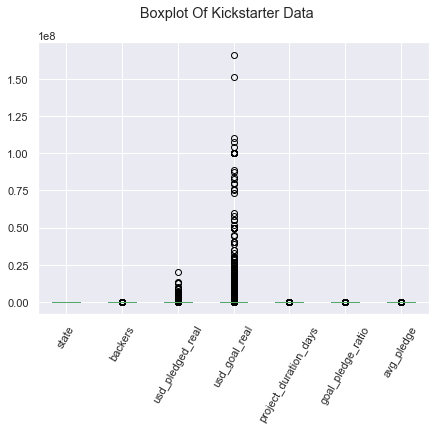

In [14]:
ks_df.plot.box(figsize=(7,5),rot=60)
plt.suptitle("Boxplot Of Kickstarter Data")

##### Removing outliers on the upper end & campaigns with unreasonably low fundraising goals

In [15]:
ks_df = ks_df[ks_df['usd_goal_real']>1000]

f_df = ks_df
bottom_10 = f_df.quantile(.10)
Q1= f_df.quantile(.25)
Q3= f_df.quantile(.75)
IQR= (Q3-Q1)

fence_high = Q3+3*IQR


#To remove outliers
filtered_df = f_df[f_df['usd_goal_real']<fence_high['usd_goal_real']]
filtered_df = filtered_df[filtered_df['backers']<fence_high['backers']]
filtered_df = filtered_df[filtered_df['usd_pledged_real']<fence_high['usd_pledged_real']]
filtered_df = filtered_df[filtered_df['usd_goal_real']<fence_high['usd_goal_real']]
filtered_df = filtered_df[filtered_df['avg_pledge']<fence_high['avg_pledge']]
filtered_df = filtered_df[filtered_df['launched_date']> datetime.date(2009,1,1)]


##### Checking the updated data set

Text(0.5, 0.98, 'Filtered Boxplot Of Kickstarter Data')

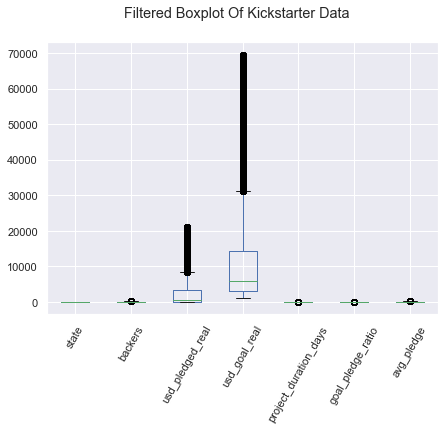

In [16]:
filtered_df.plot.box(figsize=(7,5),rot=60)
plt.suptitle("Filtered Boxplot Of Kickstarter Data")


### The two box plots above represent the final steps in cleaning our data. Outliers in this data, although from valid projects, would skew our analysis significantly.
- Instances with extremely high funding represent projects which attained viral success, while these are interesting, these will cause errors in our analysis. Some of these projects will be featured later in our analysis to understand subjective/qualitative features which contributed to their success.
- Projects with notably high or low funding goals are detrimental toward our analysis. Projects with funding goals under $1,000 are far less likely to have professional applications and skew the overall success rate. Similarly, very high funding goals indicate that the project creator has unrealistic plans for succeeding.
- Removing projects with extreme outliers in average pledge is important, due to the fact that many of these campaigns have a single backer which committed a unrealistic amount toward the given project. We are looking for how to best appeal to backers in a broad sense.

## Step 3: Analysis

##### Getting an understanding of the dispersion of each variable

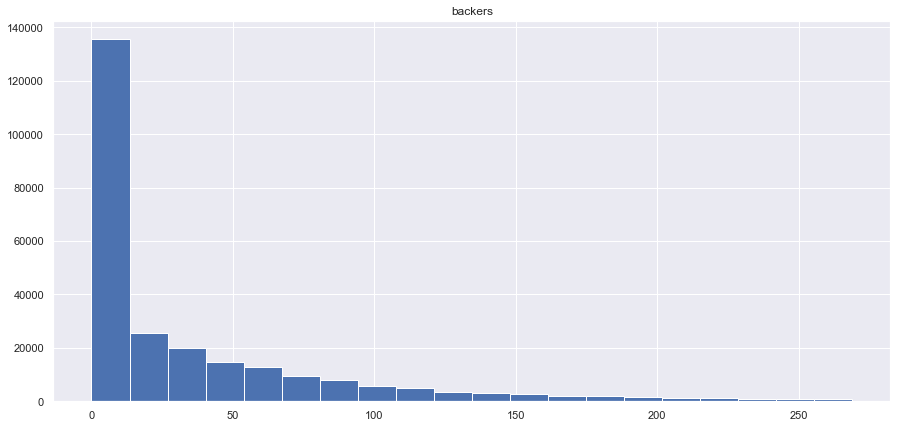

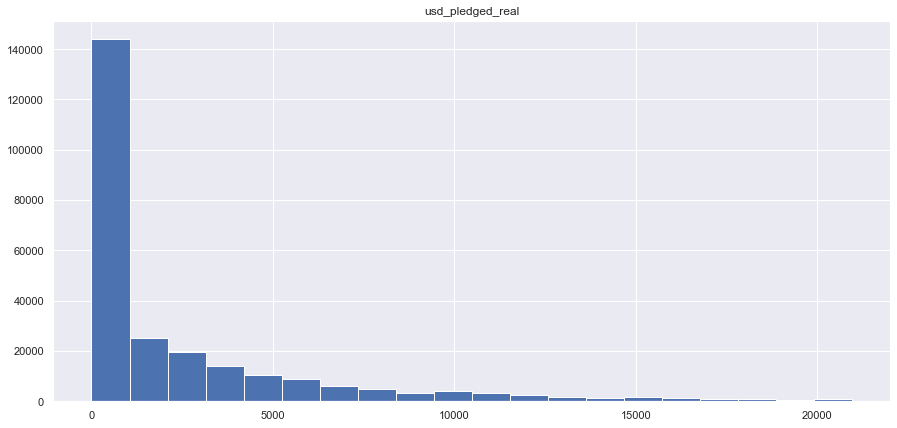

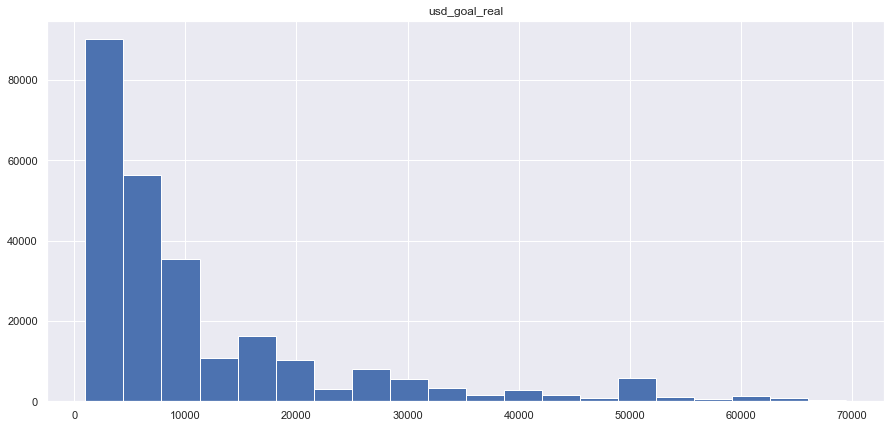

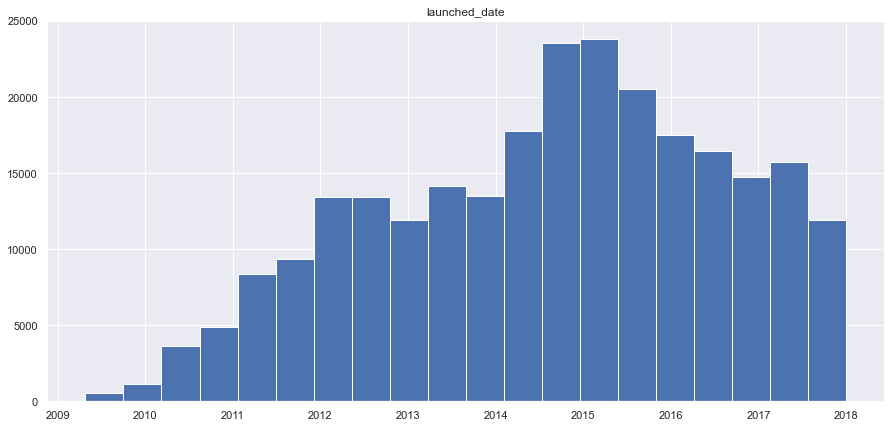

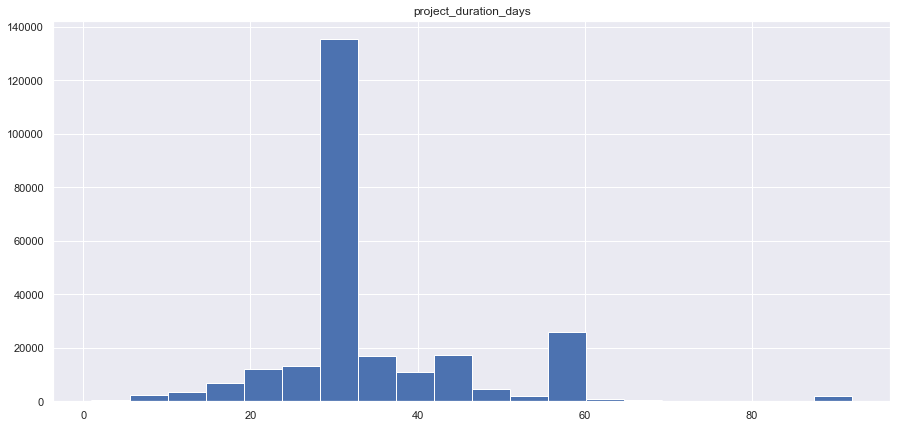

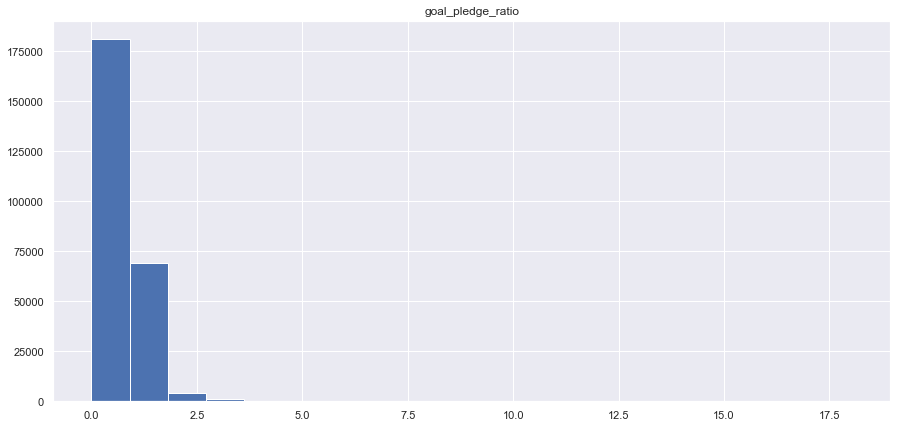

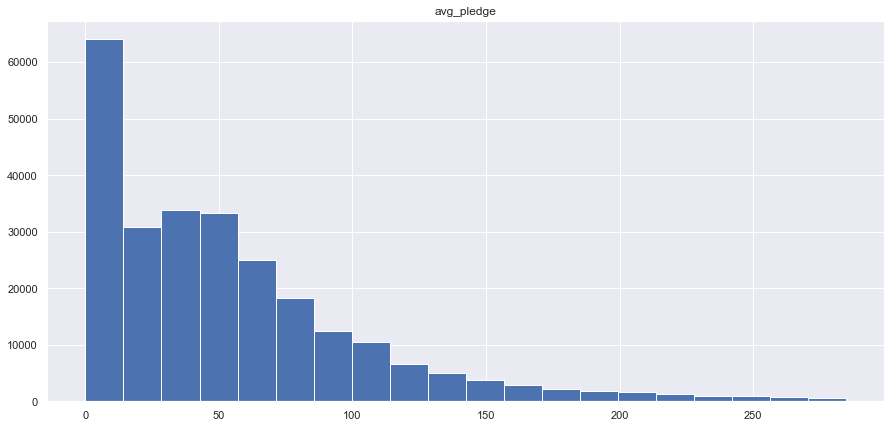

In [17]:
for a in filtered_df.drop(columns=['name','category','main_category','deadline_date','state','country']):
    fig= plt.subplots(figsize=(15, 7))
    plt.hist(filtered_df[a],bins = 20)
    plt.title(a)
    plt.show()



### The above histograms provide crucial insights into how to set goals, realistic expectations for success, and how long to run our campaign.
- For both backers and total pledged, a large portion of projects recieve very little or 0 support.
- The histogram for launch date shows an interesting trend of usage of Kickstarter for funding, the platform saw a huge spike in usage from roughly 2009-2015, and since has seen a general decline.
- Most projects are active for roughly one month, with a significant minority of campaigns lasting for 2 months.
- Average pledge is important as it provides insights into how much each backer is typically willing to spend on a project/product on Kickstarter- a large portion of projects recieve > $100 as the average pledge amount. Appropriate pricing varies by project types (ie a craft project vs high technology), thus will require further analysis to inform how we will price our project.


##### How are Kickstarter campaigns dispersed globally?

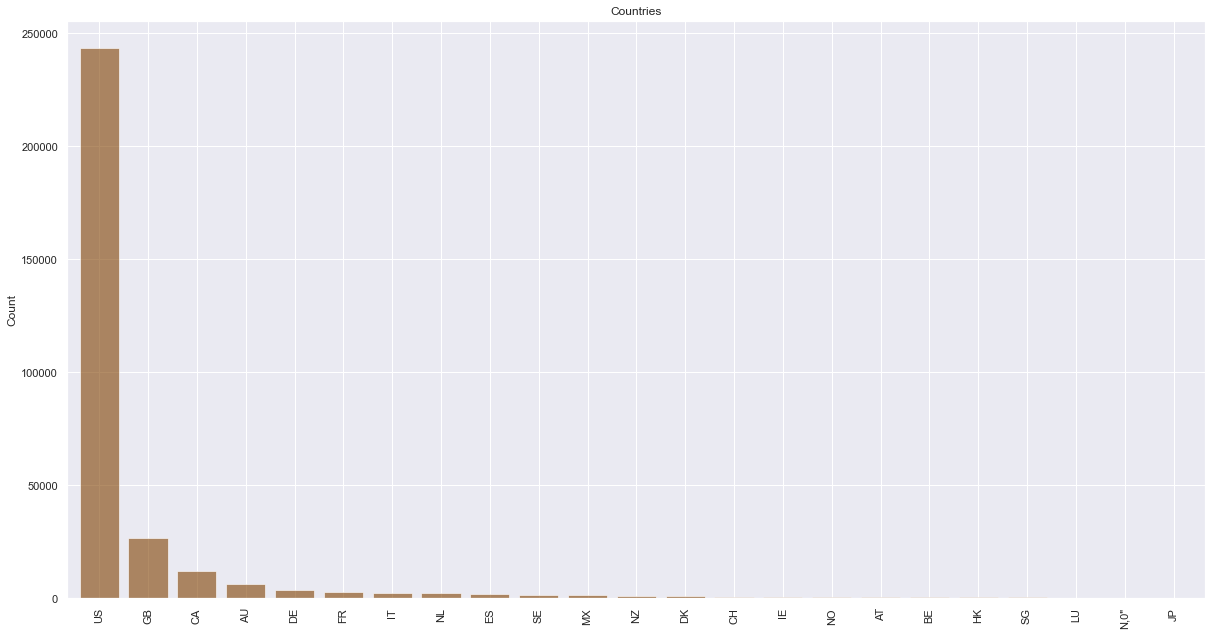

In [18]:
labels1 = filtered_df['country'].unique()

fig = plt.subplots(figsize=(17, 9))
plt.title("Countries")
plt.ylabel("Count")

ks_df['country'].value_counts().plot(kind='bar', width=.8,alpha=.6,color='#804000')


plt.tight_layout()
plt.show()

### The US makes up a huge portion of projects hosted on Kickstarter, with the next three countries being Great Britain, Canada, and Australia. All of the top 4 are English speaking countries.

##### Looking at the overall success rate

In [19]:
success_rate = len(filtered_df[filtered_df['state']==1]) / len(filtered_df) * 100

print(success_rate)

29.206395031288523


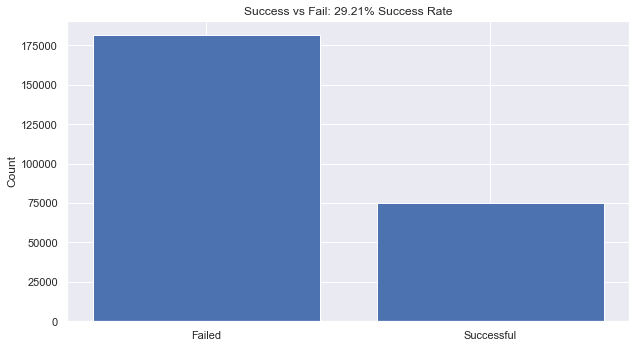

In [20]:
state = filtered_df['state'].unique()
values = ['Failed','Successful']

fig = plt.subplots(figsize=(9, 5))
plt.title("Success vs Fail: {}% Success Rate".format(round(success_rate,2)))
plt.ylabel("Count")
plt.bar(state, filtered_df['state'].value_counts(), width=.8 )
plt.xticks(state,values)


plt.tight_layout()
plt.show()

### Roungly 30% of projects will succeed

##### Creating a new dataframe to analyze campaigns by main category

In [31]:
success = filtered_df[filtered_df['state']==1]
success_category = success['main_category'].value_counts()
totals_category = filtered_df['main_category'].value_counts()
success_rate = success_category / totals_category *100

success_rate_df = success_rate.to_frame()
success_rate_df.reset_index(inplace=True)
success_rate_df.columns = ['main_category', 'success_rate']

totals_df = totals_category.to_frame()
totals_df.reset_index(inplace=True)
totals_df.columns = ['main_category', 'totals']

success_rate_df.sort_values('main_category', inplace=True)
totals_df.sort_values('main_category', inplace=True)
totals_df.reset_index(inplace=True)
success_rate_df['totals'] = totals_df['totals']


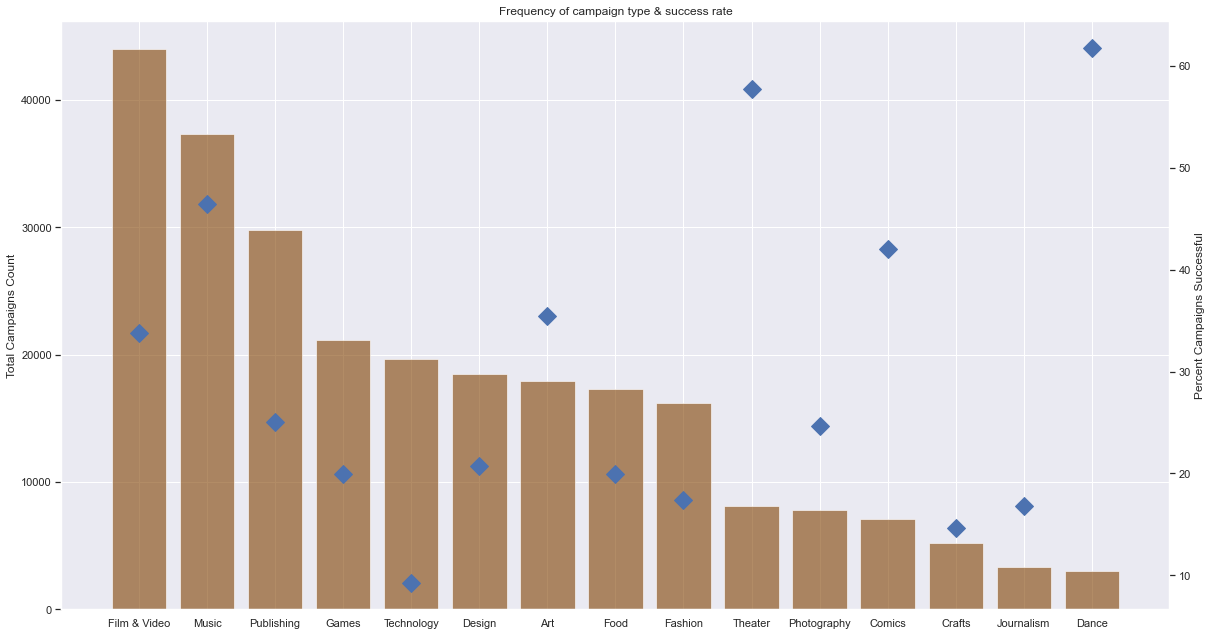

In [22]:
success_rate_df.sort_values('totals',ascending=False, inplace=True)

fig, ax1 = plt.subplots(figsize=(17, 9))

ax1.bar(success_rate_df['main_category'], success_rate_df['totals'], width=.8, alpha=.6,color='#804000')
ax1.set_ylabel('Total Campaigns Count')
ax2 = ax1.twinx()
ax2.plot(success_rate_df['main_category'],success_rate_df['success_rate'], linestyle='none', marker='D', markersize=13)
ax2.grid(b=False)
ax2.set_ylabel('Percent Campaigns Successful')

plt.title('Frequency of campaign type & success rate')


plt.tight_layout()
plt.show()



### Looking at the top  main categories:
- Film & Video projects are most popular, with a moderately high success rate just over 30%
- Music projects are the second most popular, with a very high success rate of close to 50%- I wish I had musical talent!
- Publishing projects are the third most popular with, with an success rate which is roughly average.

##### Here is the same graphic filtered by success rate rather than campaign totals

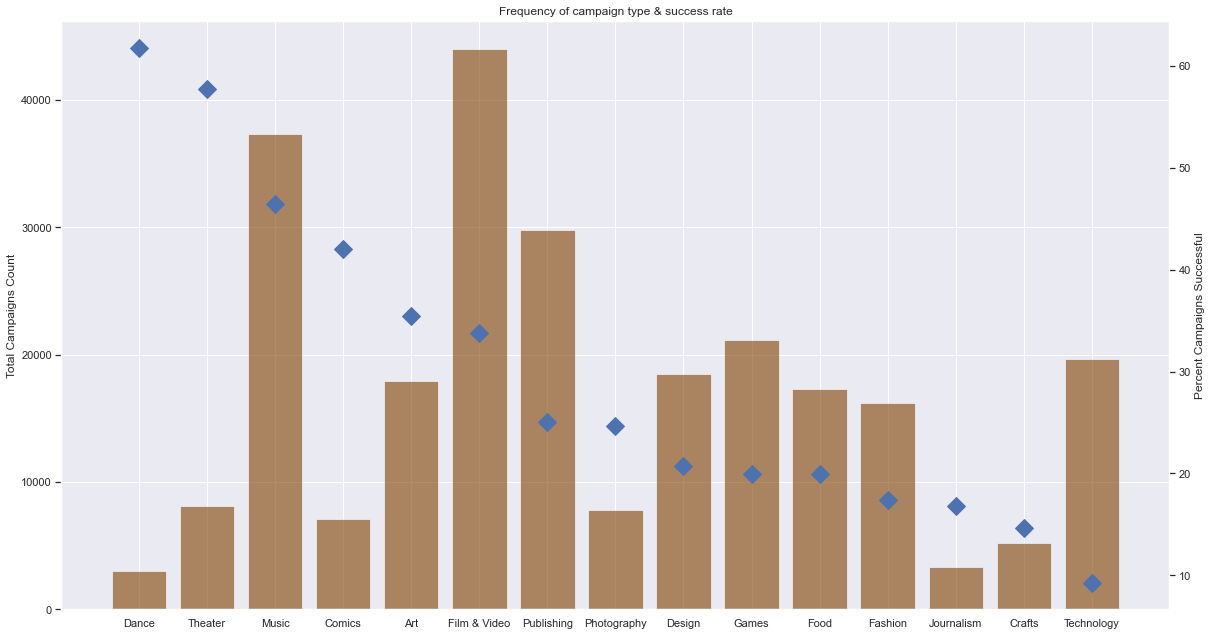

In [23]:
success_rate_df.sort_values('success_rate',ascending=False, inplace=True)

fig, ax1 = plt.subplots(figsize=(17, 9))

ax1.bar(success_rate_df['main_category'], success_rate_df['totals'], width=.8, alpha=.6,color='#804000')
ax1.set_ylabel('Total Campaigns Count')
ax2 = ax1.twinx()
ax2.plot(success_rate_df['main_category'],success_rate_df['success_rate'], linestyle='none', marker='D', markersize=13)
ax2.grid(b=False)
ax2.set_ylabel('Percent Campaigns Successful')

plt.title('Frequency of campaign type & success rate')


plt.tight_layout()
plt.show()

### Looking at top main categories (filtered by success rate):
- Dance projects are the least common main category, but by far the most successful with over 60% success rate
- Theater is similar to dance in that there are few theater projects, yet they are quite successful
- Kickstarter appears to be a platform suited very well for musicians
- Technology projects have an extremely low success rate

- Most main categories have success rates between 40-20%, but how do specific sub-categories perform?

##### Repeating the process above to look at sub-categories

In [48]:
success1 = filtered_df[filtered_df['state']==1]
success_category1 = success1['category'].value_counts()
totals_category1 = filtered_df['category'].value_counts()
success_rate1 = success_category1 / totals_category1 *100


success_rate_df1 = success_rate1.to_frame()
success_rate_df1.reset_index(inplace=True)
success_rate_df1.columns = ['category', 'success_rate']

totals_df1 = totals_category1.to_frame()
totals_df1.reset_index(inplace=True)
totals_df1.columns = ['category', 'totals']

success_rate_df1.sort_values('category', inplace=True)
totals_df1.sort_values('category', inplace=True)
totals_df1.reset_index(inplace=True)
success_rate_df1['totals'] = totals_df1['totals']

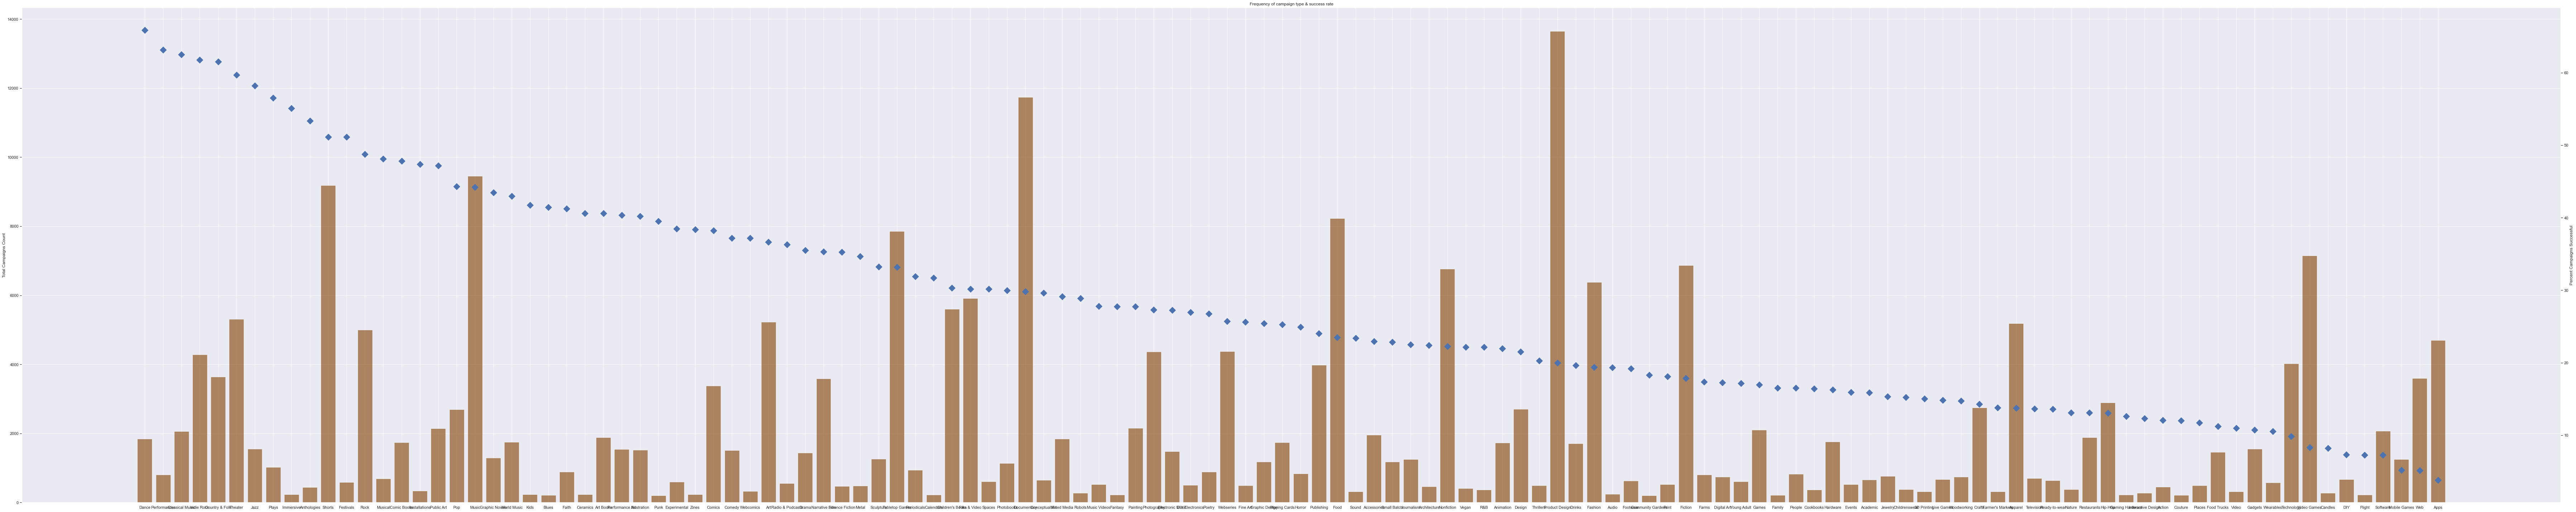

In [33]:
success_rate_df1.sort_values('success_rate',ascending=False, inplace=True)

#success_rate_df1 = success_rate_df1[success_rate_df1['success_rate'] > 40]
success_rate_df1 = success_rate_df1[success_rate_df1['totals'] > 200]

fig, ax1 = plt.subplots(figsize=(100, 20))

ax1.bar(success_rate_df1['category'], success_rate_df1['totals'], width=.8, alpha=.6,color='#804000')
ax1.set_ylabel('Total Campaigns Count')
ax2 = ax1.twinx()
ax2.plot(success_rate_df1['category'],success_rate_df1['success_rate'], linestyle='none', marker='D', markersize=13)
ax2.grid(b=False)
ax2.set_ylabel('Percent Campaigns Successful')

plt.title('Frequency of campaign type & success rate')


plt.tight_layout()
plt.show()

### Looking at sub-categories (filtered by success rate):
- There are too many sub categories to analyze efficiently in this format- we will move this to PowerBI to drill down deeper
- A preliminary analysis supports the above graphic with Dance, Music, and Theater projects at the top and tech projects near the bottom in terms of success rates

### Inferrential Statistics 

##### Let's look at a correlation heat map 

,state,backers,usd_pledged_real,usd_goal_real,project_duration_days,goal_pledge_ratio,avg_pledge
state,1.000000,0.413518,0.407117,0.089335,0.009100,0.698324,0.151124
backers,0.413518,1.000000,0.685628,0.003361,0.004485,0.454915,0.058836
usd_pledged_real,0.407117,0.685628,1.000000,0.000341,0.002187,0.400099,0.292160
usd_goal_real,0.089335,0.003361,0.000341,1.000000,0.008234,0.082444,0.002251
project_duration_days,0.009100,0.004485,0.002187,0.008234,1.000000,0.010125,0.000264
goal_pledge_ratio,0.698324,0.454915,0.400099,0.082444,0.010125,1.000000,0.132909
avg_pledge,0.151124,0.058836,0.292160,0.002251,0.000264,0.132909,1.000000


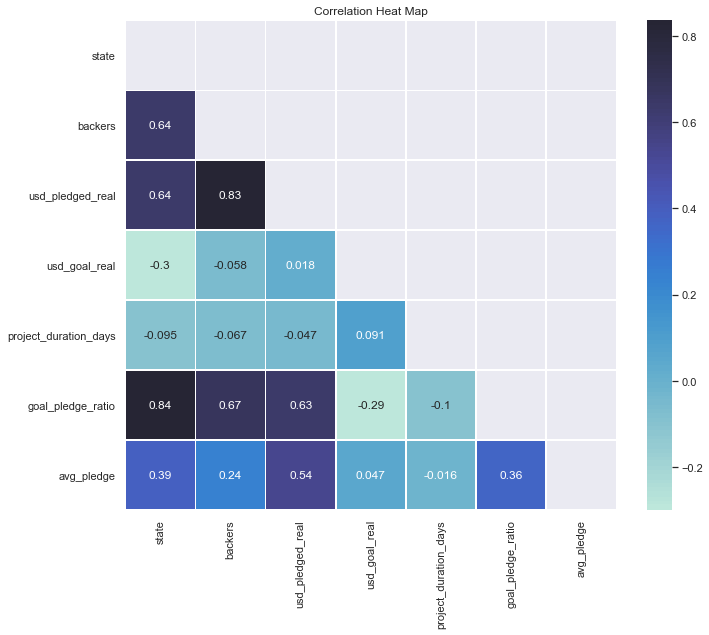

In [39]:
#This is the correlations for the filtered data- 'goal_pledge_ratio' is interesting due to the fact that it is below 1 with 'state'

corr = filtered_df.corr()
r2= np.square(corr)
fig, ax = plt.subplots(figsize=(11, 9))
plt.title("Correlation Heat Map")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, center=1, linewidths=.5, mask=mask)

r2.head(8)

### The impact that the variables have on 'state' (success), is not surprising. However, the key takeaways are the importance of attracting backers and setting attainable funding goals
- Total funding pledged to a project is expected to be critical toward a project's success, however it is interesting that the amount of backers is equally as important
- Rather than focusing entirely on attaining a funding gaol, our strategy for success should be to attract as many individual backers as possible
- Setting a funding goal is tricky. There must be a financial break even point to make our project make sense, however the higher the goal, the harder it is to attain success. We should aim to manage our project efficiently such that our minimum funding requirement is as low as possible (although we will still try to blow this goal out of the water!)

##### Now lets create a model to analyze 'Tabletop Games'
- Given that the amount of campaigns with 0 funding & 0 backers is very high, the importance of these variables may be skewed. We want to operate under the assumption that we will have at least 1 backer with some funding (Thanks, Mom!!!)

In [43]:
#prepping the data for the OLS regression

ols_df = filtered_df
ols_df = ols_df[ols_df['category']=='Tabletop Games']
ols_df = ols_df[ols_df['usd_pledged_real']>0]
ols_df = ols_df[ols_df['backers']>0]

ols_df = ols_df.drop(columns=['name','country','category','main_category','launched_date','deadline_date','goal_pledge_ratio'],axis=1)




x = ols_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ols_df1 = pd.DataFrame(x_scaled)
ols_df1 = pd.DataFrame(x_scaled, columns=ols_df.columns)


##### Lets see if the correlation heat map changes

,state,backers,usd_pledged_real,usd_goal_real,project_duration_days,avg_pledge
state,1.000000,0.349259,0.306715,0.164503,0.020627,0.030396
backers,0.349259,1.000000,0.623209,0.014637,0.016589,0.000216
usd_pledged_real,0.306715,0.623209,1.000000,0.000070,0.009303,0.198290
usd_goal_real,0.164503,0.014637,0.000070,1.000000,0.014103,0.027658
project_duration_days,0.020627,0.016589,0.009303,0.014103,1.000000,0.000138
avg_pledge,0.030396,0.000216,0.198290,0.027658,0.000138,1.000000


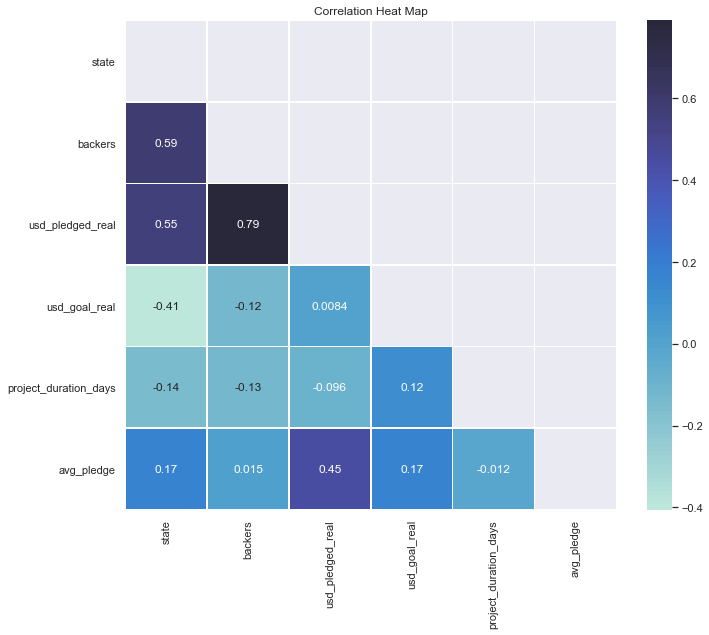

In [46]:
corr = ols_df1.corr()
r2= np.square(corr)
fig, ax = plt.subplots(figsize=(11, 9))
plt.title("Correlation Heat Map")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, center=1, linewidths=.5, mask=mask)

r2.head(8)

### When the data is filtered, backers are actually more important than funding & the negative correlation for goal on state increases
- Furthermore, the impact that average pledge has on success becomes far less important. Meaning, we will have more flexibility in terms of pricing the game options offered to our backers

In [47]:
x_col= ols_df1.columns[1:6]
x= ols_df1[x_col]
y= ols_df1['state']

x = sm.add_constant(x)

model = sm.OLS(y,x.astype(float)).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  state   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     1654.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:52:53   Log-Likelihood:                -2350.2
No. Observations:                7691   AIC:                             4712.
Df Residuals:                    7685   BIC:                             4754.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.15

In [30]:
filtered_df.to_csv('kickstarter final.csv')